In [17]:
# =========================================================
# Part 1.1: Setup and Imports
# =========================================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print("Setup Complete. TensorFlow version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup Complete. TensorFlow version: 2.19.0


In [18]:
# =========================================================
# Part 1.2: Load Raw Data from TensorFlow Datasets
# =========================================================
print("Loading CIFAR-10 dataset...")
# This single command downloads and loads the data
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar10.load_data()

# Class labels for CIFAR-10:
# 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer,
# 5: dog, 6: frog, 7: horse, 8: ship, 9: truck
CAT_CLASS_ID = 3
DOG_CLASS_ID = 5

print("Dataset loaded. Now filtering for only cats and dogs.")

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Dataset loaded. Now filtering for only cats and dogs.


In [21]:
# =========================================================
# Part 1.3: Filter for Cats vs. Dogs & Preprocess (Corrected)
# =========================================================
def filter_cats_vs_dogs(features, labels):
    cat_indices = np.where(labels == CAT_CLASS_ID)[0]
    dog_indices = np.where(labels == DOG_CLASS_ID)[0]
    combined_indices = np.concatenate([cat_indices, dog_indices])
    np.random.shuffle(combined_indices)

    filtered_features = features[combined_indices]
    filtered_labels = labels[combined_indices]

    # Remap labels: Cat (3) -> 0, Dog (5) -> 1
    remapped_labels = np.where(filtered_labels == CAT_CLASS_ID, 0, 1)

    return filtered_features, remapped_labels

# Filter the training and testing sets
x_train, y_train_temp = filter_cats_vs_dogs(x_train_all, y_train_all)
x_test, y_test_temp = filter_cats_vs_dogs(x_test_all, y_test_all)

# --- THE FIX IS HERE ---
# Flatten the label arrays to remove the extra dimension
y_train = y_train_temp.flatten()
y_test = y_test_temp.flatten()
# --- END OF FIX ---

# Normalize the image data (from 0-255 to 0-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Filtering complete.")
print(f"New training data shape: {x_train.shape}")
print(f"New training labels shape: {y_train.shape}") # Will now show (10000,)
print(f"Example labels after flattening: {y_train[:10]}") # Will be a simple array [0 1 0 ...]

Filtering complete.
New training data shape: (10000, 32, 32, 3)
New training labels shape: (10000,)
Example labels after flattening: [0 1 1 1 0 0 0 1 0 1]


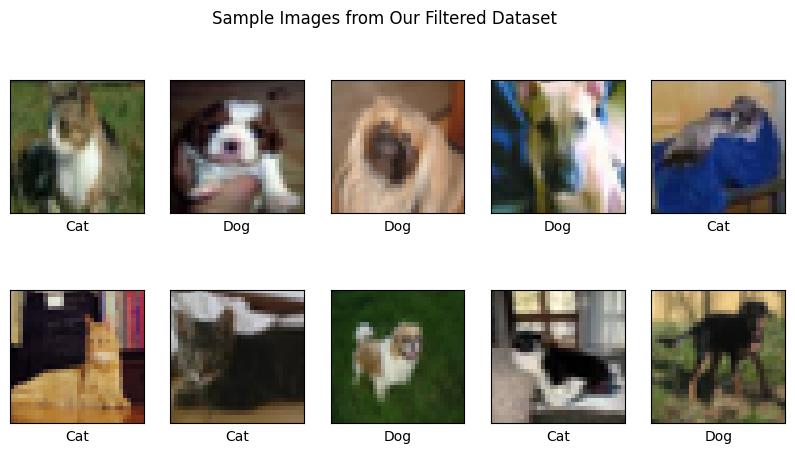

In [22]:
# =========================================================
# Part 1.4: Visualize the Data
# =========================================================
plt.figure(figsize=(10, 5))
class_names_binary = ['Cat', 'Dog']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The y_train is now 0 for cat, 1 for dog
    plt.xlabel(class_names_binary[y_train[i]])
plt.suptitle("Sample Images from Our Filtered Dataset")
plt.show()

In [23]:
# =========================================================
# Day 2: Build & Train Your First CNN Model
# =========================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# IMPORTANT: The input shape must match our new data (32x32 pixels)
IMAGE_SHAPE = (32, 32, 3)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Final output: 0 for Cat, 1 for Dog
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,065 (4.58 MB)

 Trainable params: 1,200,065 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# =========================================================
# Day 2.3: Train the Model
# =========================================================
BATCH_SIZE = 32
EPOCHS = 20 # Let's train a bit longer on this smaller dataset

print("Starting model training...")
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test))
print("Training complete.")

Starting model training...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5420 - loss: 0.6855 - val_accuracy: 0.6490 - val_loss: 0.6378
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6566 - loss: 0.6274 - val_accuracy: 0.6875 - val_loss: 0.5906
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6982 - loss: 0.5834 - val_accuracy: 0.7170 - val_loss: 0.5534
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7197 - loss: 0.5428 - val_accuracy: 0.7195 - val_loss: 0.5402
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7423 - loss: 0.5128 - val_accuracy: 0.7265 - val_loss: 0.5426
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7638 - loss: 0.4867 - val_accuracy: 0.7460 - val_loss: 0.5152
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7913 - loss: 0.4453 - val_accuracy: 0.7405 - val_loss: 0.5078
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8174 - los

Model saved to: /content/drive/My Drive/Vision_AI_Project/models/basic_cnn_model.h5
Visualization saved to: /content/drive/My Drive/Vision_AI_Project/visualizations/basic_cnn_training_curves.png


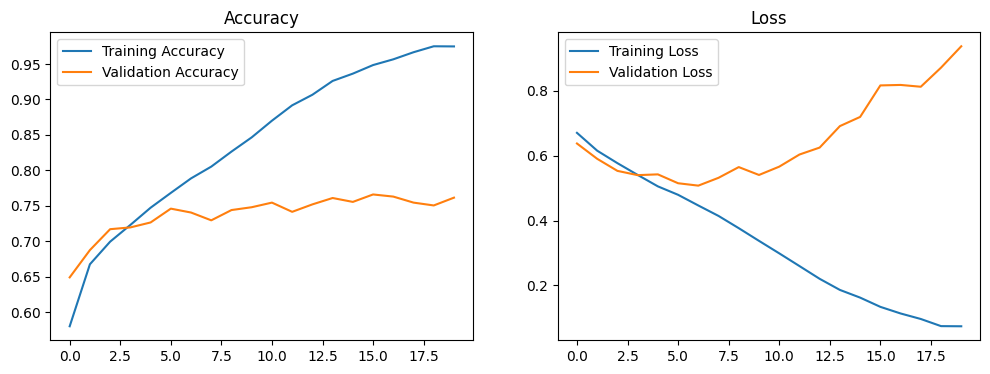

In [25]:
# =========================================================
# Day 2.4: Save the Model and Visualize Results
# =========================================================
# Define paths for saving artifacts
project_path = '/content/drive/My Drive/Vision_AI_Project'
model_save_path = os.path.join(project_path, 'models/basic_cnn_model.h5')
viz_save_path = os.path.join(project_path, 'visualizations/basic_cnn_training_curves.png')

# Create directories if they don't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
os.makedirs(os.path.dirname(viz_save_path), exist_ok=True)

# Save the trained model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.savefig(viz_save_path)
print(f"Visualization saved to: {viz_save_path}")
plt.show()

In [26]:
# =========================================================
# Day 3.1: Enhance with Data Augmentation
# =========================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the augmentation configuration
data_aug_generator = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    zoom_range=0.1,         # Randomly zoom in on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'
)

# You can now re-train your model using this generator
# For now, let's proceed to evaluate the model we already trained
print("Data Augmentation generator is ready for future training.")

Data Augmentation generator is ready for future training.


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.76      0.77      0.76      1000
         Dog       0.76      0.76      0.76      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



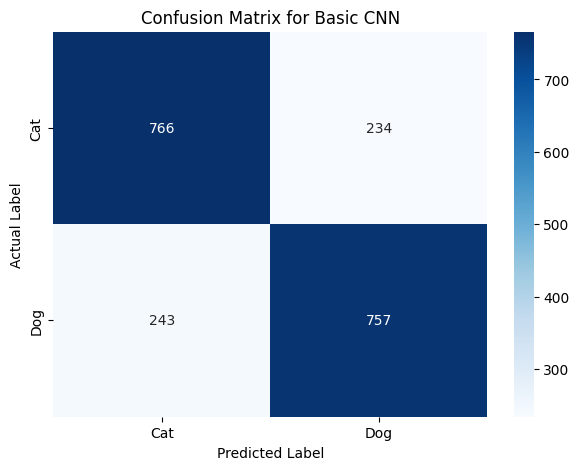

In [27]:
# =========================================================
# Day 3.2: Detailed Model Evaluation
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions from the model on the test data
predictions_prob = model.predict(x_test)
# Convert probabilities to class labels (0 or 1)
y_pred = (predictions_prob > 0.5).astype("int32").flatten()

# Print the detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix for Basic CNN')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Save the confusion matrix plot
cm_save_path = os.path.join(project_path, 'visualizations/basic_cnn_confusion_matrix.png')
plt.savefig(cm_save_path)
plt.show()

In [28]:
# =========================================================
# Day 4.1: Optimize with Transfer Learning (MobileNetV2)
# =========================================================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras.models import Model

# Define the input layer with our small image shape
input_tensor = Input(shape=(32, 32, 3))

# --- The Upsampling Trick ---
# We resize our 32x32 images to 96x96 to fit MobileNetV2's requirements
x = UpSampling2D(size=(3, 3))(input_tensor)

# Load the MobileNetV2 model without its top classification layers
base_model = MobileNetV2(input_shape=(96, 96, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model's layers so they don't get re-trained
base_model.trainable = False

# Pass our upsampled images through the base model
x = base_model(x, training=False)

# Add our own custom classifier on top
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)

# Create the final transfer learning model
transfer_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the new model
transfer_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,207,617 (19.87 MB)

 Trainable params: 2,949,633 (11.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
# =========================================================
# Day 4.2: Train the Transfer Learning Model
# =========================================================
print("Starting Transfer Learning model training...")
# Create a data flow for training with augmentation
train_flow = data_aug_generator.flow(x_train, y_train, batch_size=BATCH_SIZE)

history_transfer = transfer_model.fit(
    train_flow,
    epochs=10, # Transfer learning often needs fewer epochs
    validation_data=(x_test, y_test)
)

# Save the transfer learning model
transfer_model_save_path = os.path.join(project_path, 'models/transfer_learning_model.h5')
transfer_model.save(transfer_model_save_path)
print(f"Transfer learning model saved to: {transfer_model_save_path}")

Starting Transfer Learning model training...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.6731 - loss: 0.8374 - val_accuracy: 0.7715 - val_loss: 0.4606
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7378 - loss: 0.5163 - val_accuracy: 0.8030 - val_loss: 0.4274
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7576 - loss: 0.4954 - val_accuracy: 0.8075 - val_loss: 0.4147
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7673 - loss: 0.4924 - val_accuracy: 0.8110 - val_loss: 0.4029
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7717 - loss: 0.4804 - val_accuracy: 0.8095 - val_loss: 0.4047
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7693 - loss: 0.4784 - val_accuracy: 0.8200 - val_loss: 0.3937
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7758 - loss: 0.4639 - val_accuracy: 0.8205 - val_loss: 0.4000
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7848 - loss: 0.4601 - val_accuracy: 0.

Transfer learning model saved to: /content/drive/My Drive/Vision_AI_Project/models/transfer_learning_model.h5
